## 0. Import packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.preprocessing import LabelEncoder
# from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    roc_auc_score,
    confusion_matrix,
    precision_recall_curve,
    average_precision_score,
    roc_curve,
    auc
)

import seaborn as sns

import re
import ast

In [2]:
# Symptom stop words - global variable declaration

stop_words = {"symptoms", "signs", "aaa", "zika virus"}

## 1. Ingest Data to pandas dataframe

In [3]:
df = pd.read_csv("symptoms_ner (3).csv")

df.drop(columns = ["symptoms.1"], inplace=True)

In [4]:
df.head()

,disease_name,symptoms,source,processed_symptoms,named_entities
0,a-fib (atrial fibrillation),"A heartbeat that races, pounds, or flutters We...",drugs-com,heartbeat race pound flutter weakness severe t...,"['heartbeat', 'races', 'pounds', 'flutters wea..."
1,abnormal (dysfunctional) uterine bleeding,Bleeding or spotting between periods Bleeding ...,drugs-com,bleed spot period bleed start 12 month long me...,"['bleeding', 'periods bleeding', 'months', 'lo..."
2,abscess,You may have a swollen mass that is red and pa...,drugs-com,swollen mass red painful pus leak mass pus whi...,"['swollen mass', 'red', 'painful', 'pus', 'lea..."
3,abscess in children,Your child may have a swollen mass that is red...,drugs-com,child swollen mass red painful pus leak mass p...,"['child', 'swollen mass', 'red', 'painful', 'p..."
4,abuse of alcohol,"Loss of interest in activities, work, and scho...",drugs-com,loss interest activity work school hiding alco...,"['activities', 'work', 'school hiding', 'drink..."


## 2. Clean named entities column for symptoms

In [5]:
def clean_named_entities(row, entity_column = 'named_entities'):
    """
        Function to clean named entities
        Steps taken to clean named entities
        1. Convert string formatted list to python list, as the csv already converted list to string
        2. Remove disease names from named entities
        3. Put each entity to lower case
        4. Strip trailing and leading white spaces for each named entity
        5. Remove non-alphanumeric characters for each named entity
    """
    disease = row['disease_name'].lower()  # Convert disease name to lowercase

    row[entity_column] = ast.literal_eval(row[entity_column]) # convert string to list
    
    # Remove disease name and stop words and clean text
    cleaned_entities = [
        re.sub(r"[^a-zA-Z0-9\s]", "", ent).strip()  # Remove non-alphabetic characters
        for ent in row[entity_column] if ent.lower() not in ({disease} | stop_words)
    ] 
    return cleaned_entities

In [6]:
print(clean_named_entities.__doc__)


        Function to clean named entities
        Steps taken to clean named entities
        1. Convert string formatted list to python list, as the csv already converted list to string
        2. Remove disease names from named entities
        3. Put each entity to lower case
        4. Strip trailing and leading white spaces for each named entity
        5. Remove non-alphanumeric characters for each named entity
    


In [7]:
# Apply the function
df['named_entities'] = df.apply(clean_named_entities, axis=1)

## 3. Train test split

In [8]:
# Initialize the encoder
label_encoder = LabelEncoder()

# Perform label encoding
df['disease_name_encoded'] = label_encoder.fit_transform(df['disease_name'])

# Check the encoded result
print(df[['disease_name', 'disease_name_encoded']].head())

                                disease_name  disease_name_encoded
0                a-fib (atrial fibrillation)                     0
1  abnormal (dysfunctional) uterine bleeding                     1
2                                    abscess                     2
3                        abscess in children                     3
4                           abuse of alcohol                     4


In [9]:
X = df['named_entities']
y = df['disease_name_encoded']

In [10]:
# Split the data into training and testing sets
# X_train, _, y_train, _ = train_test_split(X, y, test_size=0.2, 
#                                                     random_state=42, stratify=y)

X_train = X
y_train = y

## 4. Feature Extraction

In [11]:
# 1. Directly use the lists of entities
vectorizer = CountVectorizer(max_features=200,  # you can adjust max features to retain 
                             tokenizer=lambda x: x, lowercase=False)  # Treats lists as token sequences
count_matrix = vectorizer.fit_transform(X_train)

# 2. Convert Count Matrix to TF-IDF
tfidf_transformer = TfidfTransformer()
tfidf_matrix = tfidf_transformer.fit_transform(count_matrix)

# Convert to DataFrame for analysis
feature_names = vectorizer.get_feature_names_out()

C:\Users\USER\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [12]:
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names)

# Display TF-IDF features
display(tfidf_df.head())
print()
print(tfidf_df.shape)

,abdomen,abdominal pain,activity,affected,age,amount,anaphylaxis,ankle,anxiety,area,...,weeks,weight gain,weight loss,wheezing,white,whites,worse,wound,wrist,years
0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.231059,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.357624,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.289596,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0



(1235, 200)


In [13]:
# Change the intervals in iloc[start:end] at intervals of 50
# to display rows in the pandas Series

display(tfidf_df.sum(axis=0).iloc[300:350])

Series([], dtype: float64)

## 5. Principal Component Analysis

In [14]:
from sklearn.decomposition import PCA

n_components = 100

In [15]:
pca = PCA(n_components=n_components)
train_X_pca = pca.fit_transform(tfidf_matrix)
# test_X_pca = pca.transform(X_test_tfidf)

In [16]:
def calculate_cum_var_exp(eig_vals):
    tot = sum(eig_vals)

    var_exp = []
    for i in eig_vals:
        var_i = (i / tot)*100
        var_exp.append(var_i)
    cum_var_exp = np.cumsum(var_exp)
    return cum_var_exp

total_variance = pca.explained_variance_.sum()
pca_variance = list(zip(range(1, len(pca.explained_variance_) + 1), (100 * pca.explained_variance_/total_variance)))
cum_pca_variance= calculate_cum_var_exp(pca.explained_variance_)

cum_pca_variance

array([  3.31552819,   5.97243349,   8.33884385,  10.58740949,
        12.78939563,  14.75768008,  16.67225296,  18.48889701,
        20.2661692 ,  21.97559025,  23.66666468,  25.3274904 ,
        26.89794378,  28.41807647,  29.92071089,  31.38981609,
        32.80960528,  34.19792963,  35.56337401,  36.89235438,
        38.16741117,  39.43908324,  40.69121295,  41.92263655,
        43.14520026,  44.3388213 ,  45.51239046,  46.66470863,
        47.76913498,  48.85097085,  49.91962072,  50.98314131,
        52.03307382,  53.05999816,  54.07871828,  55.09094989,
        56.09969919,  57.08180694,  58.05149197,  59.01313121,
        59.95228434,  60.88149474,  61.80183464,  62.71680783,
        63.62479979,  64.51998287,  65.38713721,  66.24259627,
        67.08706403,  67.91619029,  68.74355369,  69.55414291,
        70.35538649,  71.14935663,  71.93363948,  72.70705968,
        73.47809744,  74.24483422,  75.00570887,  75.75122052,
        76.4858162 ,  77.21135193,  77.92945732,  78.63

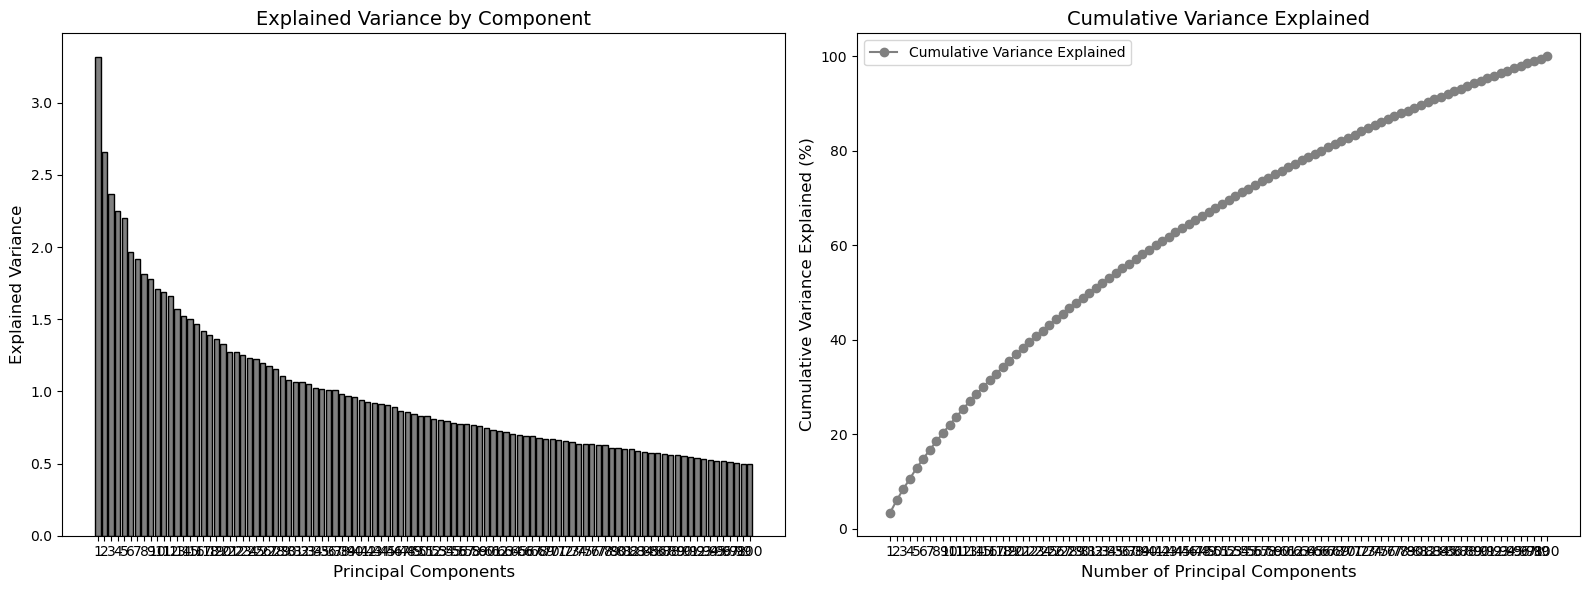

In [17]:
# Unpack the principal components and their explained variance
components, explained_variance = zip(*pca_variance)

# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Histogram of explained variance ratios
axes[0].bar(components, explained_variance, color='grey', edgecolor='black')
axes[0].set_xlabel('Principal Components', fontsize=12)
axes[0].set_ylabel('Explained Variance', fontsize=12)
axes[0].set_title('Explained Variance by Component', fontsize=14)
axes[0].set_xticks(components)

# Plot 2: Plot cumulative variance explained vs number of components
axes[1].plot(
    range(1, n_components+1),  # Adjust based on the number of components
    (cum_pca_variance),  # Matching cumulative variance formula
    marker='o',
    linestyle='-',
    color='grey',
    label='Cumulative Variance Explained'
)
axes[1].set_xlabel('Number of Principal Components', fontsize=12)
axes[1].set_ylabel('Cumulative Variance Explained (%)', fontsize=12)
axes[1].set_title('Cumulative Variance Explained', fontsize=14)
axes[1].tick_params(axis='both', labelsize=10)
axes[1].set_xticks(np.arange(1, n_components + 1, 1))
axes[1].legend(fontsize=10)

# Adjust layout for better spacing
plt.tight_layout()
plt.savefig("principal_component_analysis.png", dpi=200)
plt.show()

In [18]:
# Number of top named entiities to display for each principal component
n_top_words = 10

# Create a list to store summaries for each principal component
component_summaries = []

print('Principal Component Top Words')
print('-----', '-'*80)

# Iterate through each principal component
for i, component in enumerate(pca.components_):
    # Sort the words by their importance (loadings) for this principal component
    top_word_indices = np.argsort(np.abs(component))[::-1][:n_top_words]  # Get indices of top n words
    top_words = feature_names[top_word_indices]  # Get the actual words using the indices
    component_summaries.append(' '.join(top_words))

    # Print out the top words for the component
    print('  %3d %s' % (i, ' '.join(top_words)))

Principal Component Top Words
----- --------------------------------------------------------------------------------
    0 pain swelling tenderness nausea confusion abdomen movement vomiting child days
    1 abdomen skin child red vomiting nausea diarrhea urine painful abdominal pain
    2 child skin childs red painful eye mouth severe blisters swollen
    3 abdomen urine red child changes skin fever urinate weakness days
    4 pain severe vomiting urinate headache fever days nausea abdomen diarrhea
    5 severe diarrhea movement bowel abdomen skin abdominal pain confusion vomiting nausea
    6 swelling cough pain redness changes shortness skin worse neck chest
    7 mouth eyes cough skin urine neck severe weakness bowel swelling
    8 swelling abdomen urinate skin mouth legs child fatigue feet days
    9 severe movement bowel mouth changes mild pain tenderness worse leg
   10 mouth eye red changes skin fever swollen legs sores feet
   11 abdomen urine abdominal pain urinate urinating 

## 6. Supervised Learning

* 6.1 Random Forest Classifier
* ~~6.2 Gradient Boosting Classifier~~
* ~~6.3 XGBoost Classifier~~

In [19]:
def show_summary_report(actual, prediction, probabilities):
    # If actual labels is a Series, extract the array
    if isinstance(actual, pd.Series):
        actual = actual.values
    # If actual and/or prediction labels are strings, convert to integers
    if actual.dtype.name == 'object':
        actual = actual.astype(int)
    if prediction.dtype.name == 'object':
        prediction = prediction.astype(int)

    # Calculate model evaluation metrics
    accuracy_ = accuracy_score(actual, prediction)
    precision_ = precision_score(actual, prediction, average='macro')  # Macro-averaged for multi-class
    recall_ = recall_score(actual, prediction, average='macro')        # Macro-averaged for multi-class
    roc_auc_ = roc_auc_score(actual, probabilities, multi_class='ovr', average='macro')

    print('Accuracy : %.4f [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0' % accuracy_)
    print('Precision: %.4f [Macro-average across classes]' % precision_)
    print('Recall   : %.4f [Macro-average across classes]' % recall_)
    print('ROC AUC  : %.4f [OvR Macro-average]' % roc_auc_)
    print('-' * 107)

    return accuracy_, precision_, recall_, roc_auc_

### 6.1 Random Forest Classifier

In [20]:
# Initialize a dataframe to store results
results = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'ROC_AUC'])

# Initialize the model
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier with the training data
rf_clf.fit(tfidf_matrix, y)

# Make predictions on the test data
predictions = rf_clf.predict(tfidf_matrix)

# Store probabilities of predictions being 1
probabilities = rf_clf.predict_proba(tfidf_matrix)

In [32]:
for i in range(130, 150): # check output
    print((probabilities[:,i].argmax(), probabilities[:,i].max()))

(134, 0.66)
(135, 0.6)
(136, 0.41283333333333333)
(137, 0.3215317460317459)
(138, 0.69)
(139, 0.3947142857142857)
(140, 0.67)
(141, 0.67)
(142, 0.57)
(143, 0.62)
(144, 0.7)
(145, 0.4228333333333334)
(136, 0.4771666666666667)
(147, 0.65)
(148, 0.270297619047619)
(149, 0.65)
(150, 0.39)
(150, 0.4599999999999999)
(152, 0.62)
(153, 0.62)


In [33]:
# Display the disease name that did not return good results

# print(f"Actual was {df.disease_name.iloc[36]}, but predicted {df.disease_name.iloc[18]}")
# print(f"Actual was {df.disease_name.iloc[85]}, but predicted {df.disease_name.iloc[47]}")
# --- etc

In [23]:
accuracy_, precision_, recall_, roc_auc_ = show_summary_report(y_train, predictions, probabilities)

C:\Users\USER\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy : 0.9449 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.9229 [Macro-average across classes]
Recall   : 0.9439 [Macro-average across classes]
ROC AUC  : 0.9999 [OvR Macro-average]
-----------------------------------------------------------------------------------------------------------


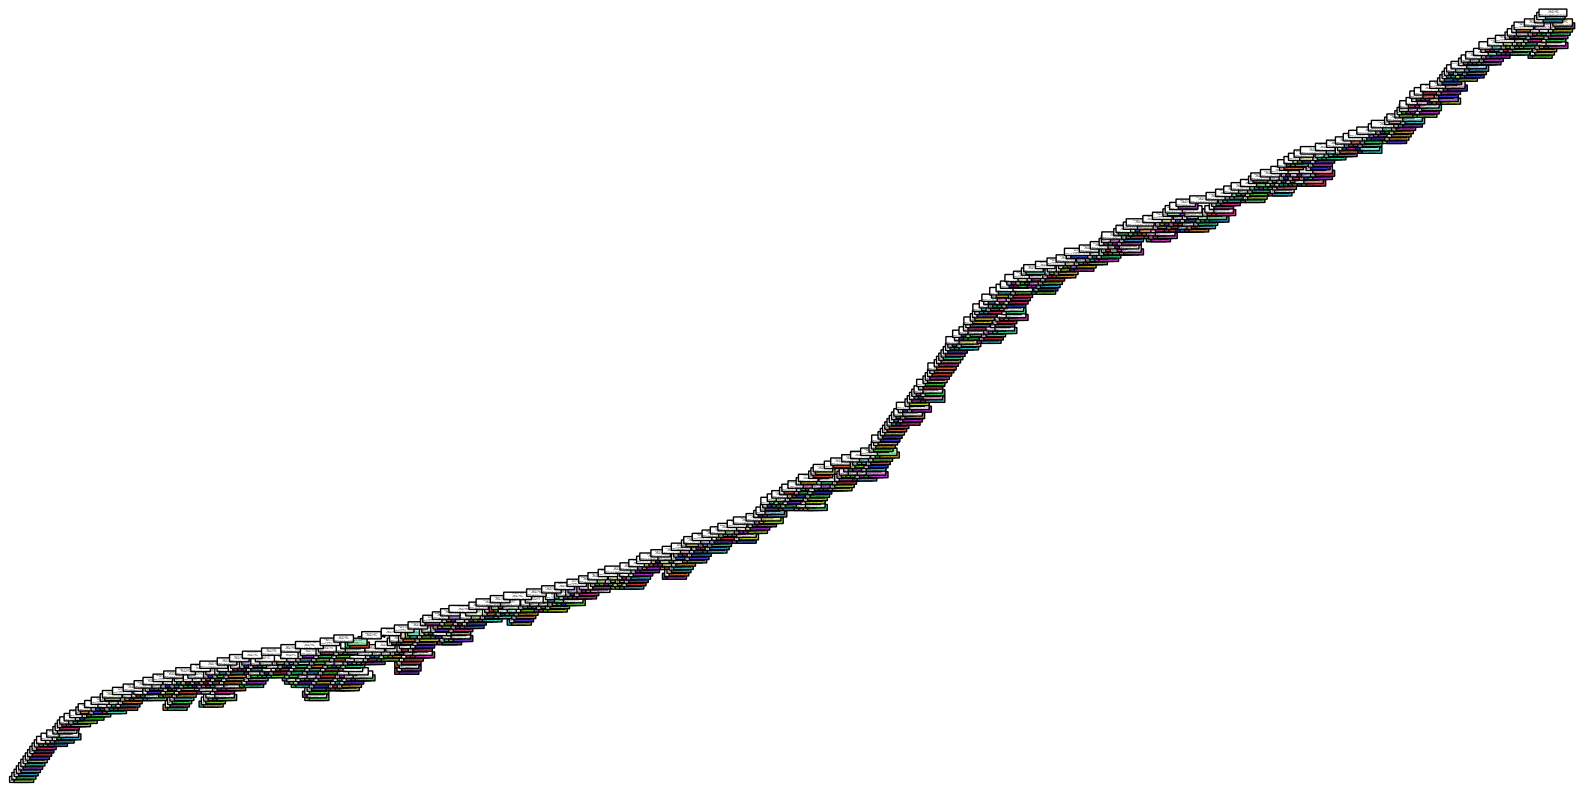

In [24]:
from sklearn.tree import plot_tree

# Convert class names to strings to avoid TypeError
class_names = [str(cls) for cls in rf_clf.classes_]

# Plot the first tree in the forest
plt.figure(figsize=(20,10))
plot_tree(rf_clf.estimators_[0], filled=True, feature_names=feature_names, class_names=class_names, rounded=True)
plt.show()